# Clustering
xxx

### Data Sources

Cleaned datafiles, as prepared in notebook 1: `profile_type_clean.csv`: demographic data and KPI for each of the offer types per customer.

### Changes

- 2019-01-24: Started notebook


In [1]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats

from sklearn.preprocessing import minmax_scale, maxabs_scale, robust_scale, StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [2]:
# import preparated data

profile_type_file = Path.cwd() / "data" / "processed" / "profile_type_clean.csv"
profile_type = pd.read_csv(profile_type_file, index_col = 0, dtype={'gender' : 'category'})

## Construct dataset for clustering

We will try to find cluster based on customer behaviour only, this means that socio-demographic features are omitted from the data set.

In [3]:
display(profile_type)
display(profile_type.info())

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,1.000000,2.0,9.0,20.40,5.0,15.40,0.245098,2.266667,0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,2.0,5.0,9.0,20.400,0.0,0.0,0.000
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.750000,0.0,6.0,15.62,5.0,10.62,0.320102,2.603333,3,7.69,2.563333,0.500000,0.492318,0.0,2.0,3.0,7.930,0.0,0.0,0.0,0.000,1.0,0.0,0.000
p_100,68.0,F,84000.0,-725,5.0,0.0,1.0,0.000000,0.0,2.0,34.04,2.0,32.04,0.058754,17.020000,2,34.04,17.020000,1.000000,1.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000
p_1000,67.0,M,44000.0,-225,4.0,4.0,0.0,1.000000,0.0,5.0,19.78,0.0,19.78,0.000000,3.956000,2,13.37,6.685000,0.400000,0.675935,0.0,3.0,3.0,5.555,0.0,0.0,0.0,0.000,1.0,1.0,0.855
p_10000,NaN,NaN,NaN,-446,3.0,3.0,0.0,1.000000,0.0,6.0,7.28,0.0,7.28,0.000000,1.213333,1,1.83,1.830000,0.166667,0.251374,0.0,2.0,4.0,3.935,0.0,1.0,3.0,1.515,0.0,0.0,0.000
p_10001,56.0,F,71000.0,-716,5.0,5.0,4.0,1.000000,4.0,17.0,289.20,19.0,270.20,0.065698,17.011765,13,228.10,17.546154,0.764706,0.788728,1.0,1.0,1.0,7.310,3.0,3.0,4.0,53.790,1.0,0.0,0.000
p_10002,69.0,M,62000.0,-977,2.0,0.0,1.0,0.000000,0.0,8.0,139.84,5.0,134.84,0.035755,17.480000,8,139.84,17.480000,1.000000,1.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000
p_10003,66.0,F,74000.0,-72,3.0,2.0,2.0,0.666667,2.0,3.0,58.96,12.0,46.96,0.203528,19.653333,1,14.91,14.910000,0.333333,0.252883,1.0,1.0,1.0,15.090,1.0,1.0,1.0,28.960,0.0,0.0,0.000
p_10004,64.0,M,53000.0,-54,5.0,4.0,0.0,0.800000,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,4.0,0.0,0.000,0.0,0.0,0.000
p_10005,28.0,M,64000.0,-295,6.0,4.0,2.0,0.666667,2.0,7.0,19.34,4.0,15.34,0.206825,2.762857,3,8.01,2.670000,0.428571,0.414168,0.0,2.0,2.0,2.740,2.0,2.0,2.0,8.590,0.0,0.0,0.000


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 31 columns):
age                   14825 non-null float64
gender                14825 non-null category
income                14825 non-null float64
member_days           17000 non-null int64
offer_received        17000 non-null float64
offer_viewed          17000 non-null float64
offer_completed       17000 non-null float64
viewed_received       17000 non-null float64
completed_viewed      17000 non-null float64
total_trans           17000 non-null float64
total_amount          17000 non-null float64
total_reward          17000 non-null float64
total_profit          17000 non-null float64
prop_reward           17000 non-null float64
total_mean_amount     17000 non-null float64
np_trans              17000 non-null int64
np_amount             17000 non-null float64
np_mean_amount        17000 non-null float64
prop_np_trans         17000 non-null float64
prop_np_amount        17000 non-null floa

None

In [4]:
"""calculate some additional ratios"""

profile_type['prop_bogo_amount'] = profile_type['bogo_amount'] / profile_type['total_amount']
profile_type['prop_discount_amount'] = profile_type['discount_amount'] / profile_type['total_amount']
profile_type['prop_info_amount'] = profile_type['info_amount'] / profile_type['total_amount']

profile_type['bogo_vtc'] = profile_type['bogo_completed'] / profile_type['bogo_viewed']
profile_type['discount_vtc'] = profile_type['discount_completed'] / profile_type['discount_viewed']

profile_type['complete_by_accident'] = profile_type['offer_completed'] - profile_type['completed_viewed']

# eliminate NaN in aggregated data and check results
profile_type.iloc[: , 4:] = profile_type.iloc[: , 4:].fillna(value=0.0)
display(profile_type.head(2))

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,complete_by_accident
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,1.00,2.0,9.0,20.40,5.0,15.40,0.245098,2.266667,0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,2.0,5.0,9.0,20.4,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.4,0.0
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.75,0.0,6.0,15.62,5.0,10.62,0.320102,2.603333,3,7.69,2.563333,0.5,0.492318,0.0,2.0,3.0,7.93,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.507682,0.0,0.0,0.0,0.0,1.0


In [5]:
"""select relevant columns for clustering"""

profile = profile_type[['viewed_received', 'total_trans', 'total_amount', 'prop_np_amount', 'bogo_completed', 'bogo_viewed', 
                        'prop_bogo_amount', 'discount_completed', 'discount_viewed', 'prop_discount_amount', 'info_viewed', 
                       'prop_info_amount', 'complete_by_accident']]

## Pre-process features

### Check data structure

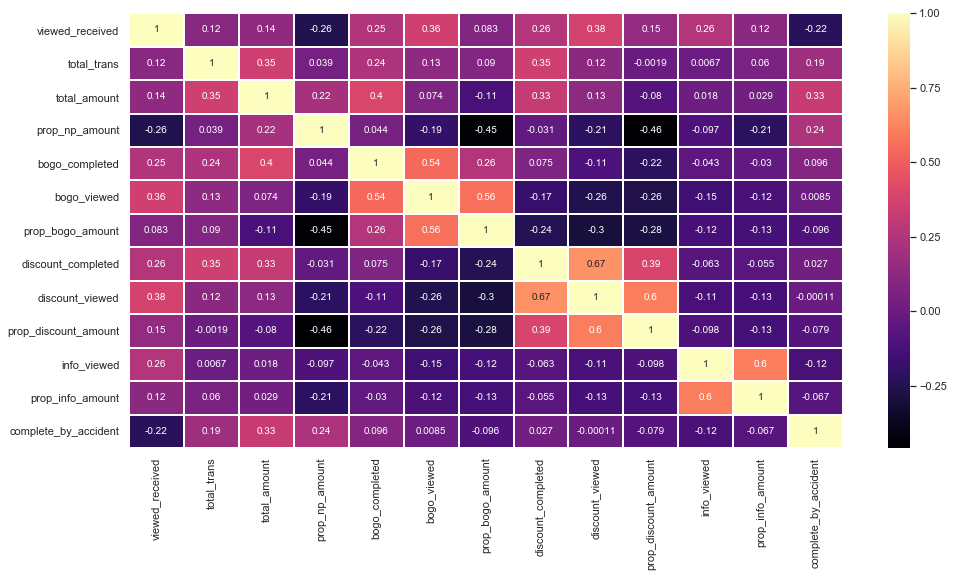

In [6]:
"""show correlation between features"""

EDA.plot_num_corrMap(profile, figsize=(16, 8))

**Observation:** There are no very high correlated features that would have to be eliminated.

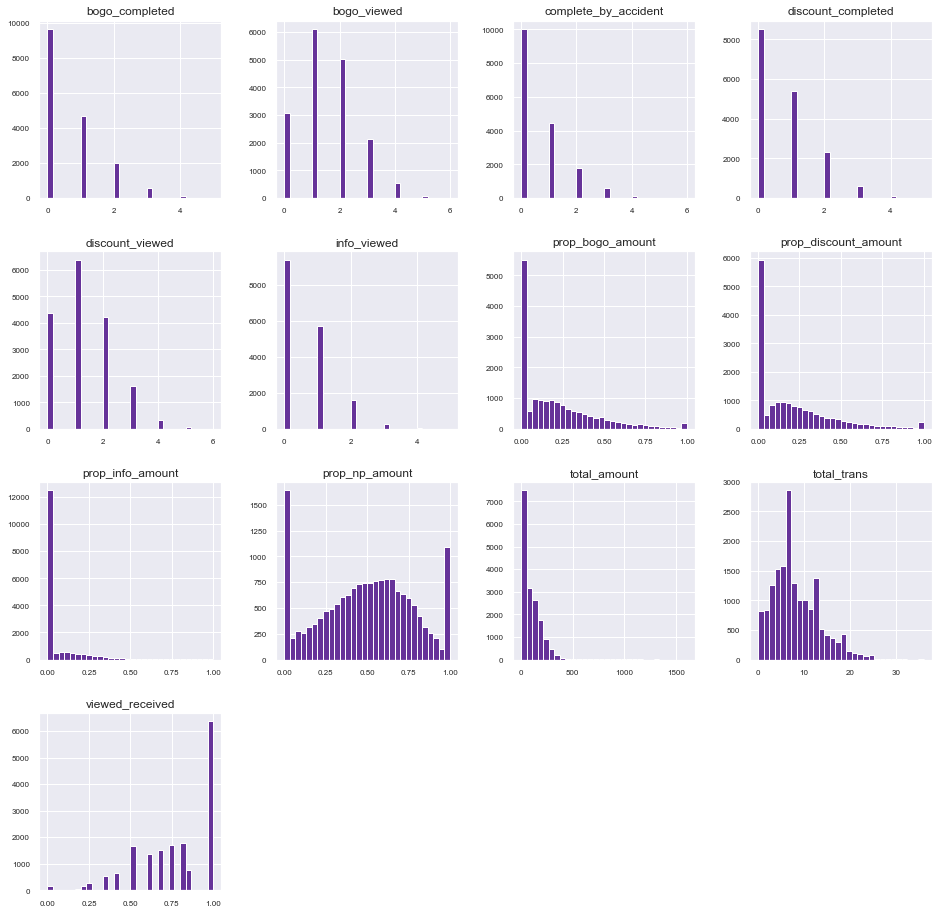

In [7]:
"""plot histograms of numerical data"""

EDA.plot_num_hist(profile, figsize=(16, 16), bins=30)

### Create PCA-Sets 1: Scaled

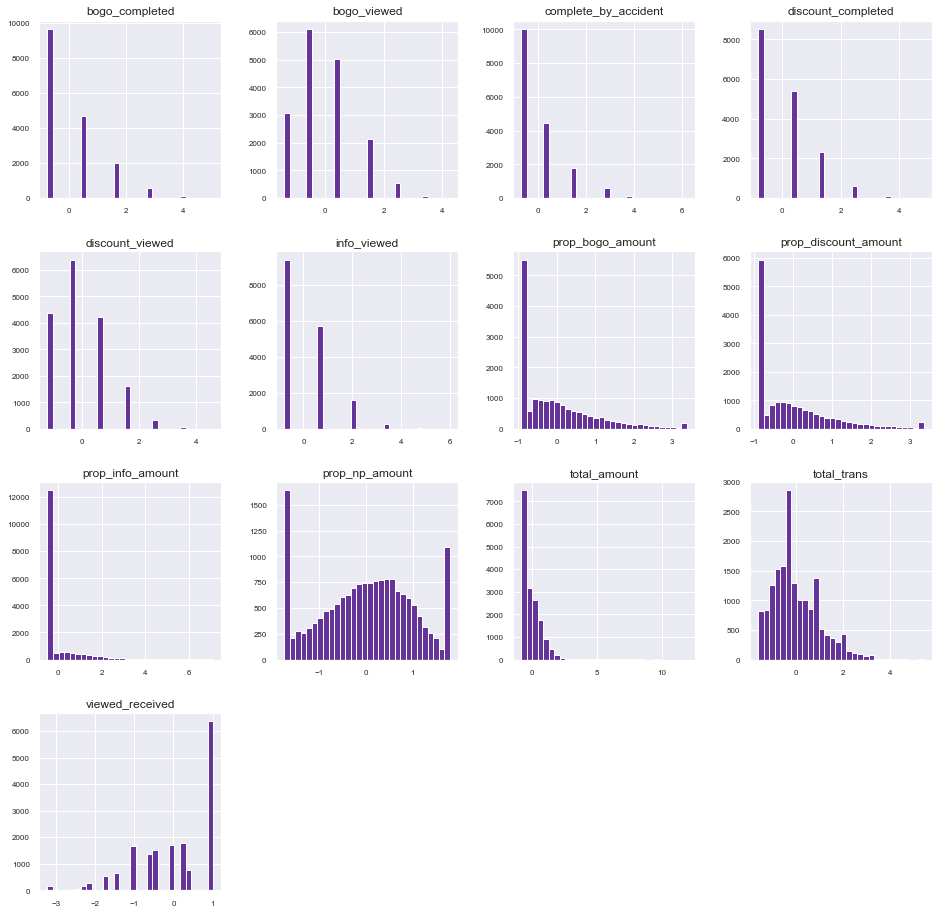

In [8]:
"""Standard scaling (outliers not removed)"""

scaler = StandardScaler().fit(profile)
standard_profile = scaler.transform(profile)
standard_profile = pd.DataFrame(scaler.transform(profile), columns=profile.columns)

# check results
EDA.plot_num_hist(standard_profile, figsize=(16, 16), bins=30)

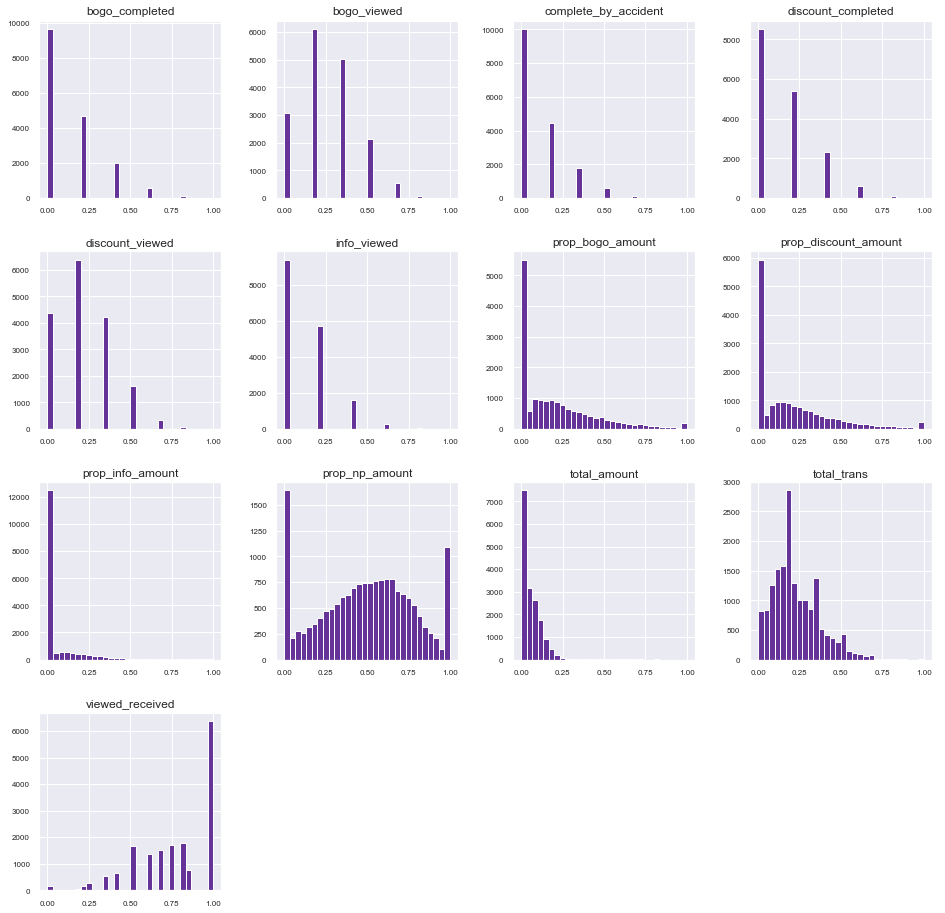

In [9]:
"""Robust scaling (outliers not removed)"""

robust_profile = minmax_scale(profile)
robust_profile = pd.DataFrame(robust_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(robust_profile, figsize=(16, 16), bins=30)

In [10]:
"""Min-Max-Scaling, outliers removed (not for prop_info_amount!)"""

# clean outliers for total transactions, total amount
minmax_profile = profile.copy()
cleaning.remove_outliers_IQR_method(minmax_profile, outlier_cols=['total_amount', 'total_trans'])
len(minmax_profile)

total_amount
Rows removed: 521

total_trans
Rows removed: 265


Rows removed in total: 786



16214

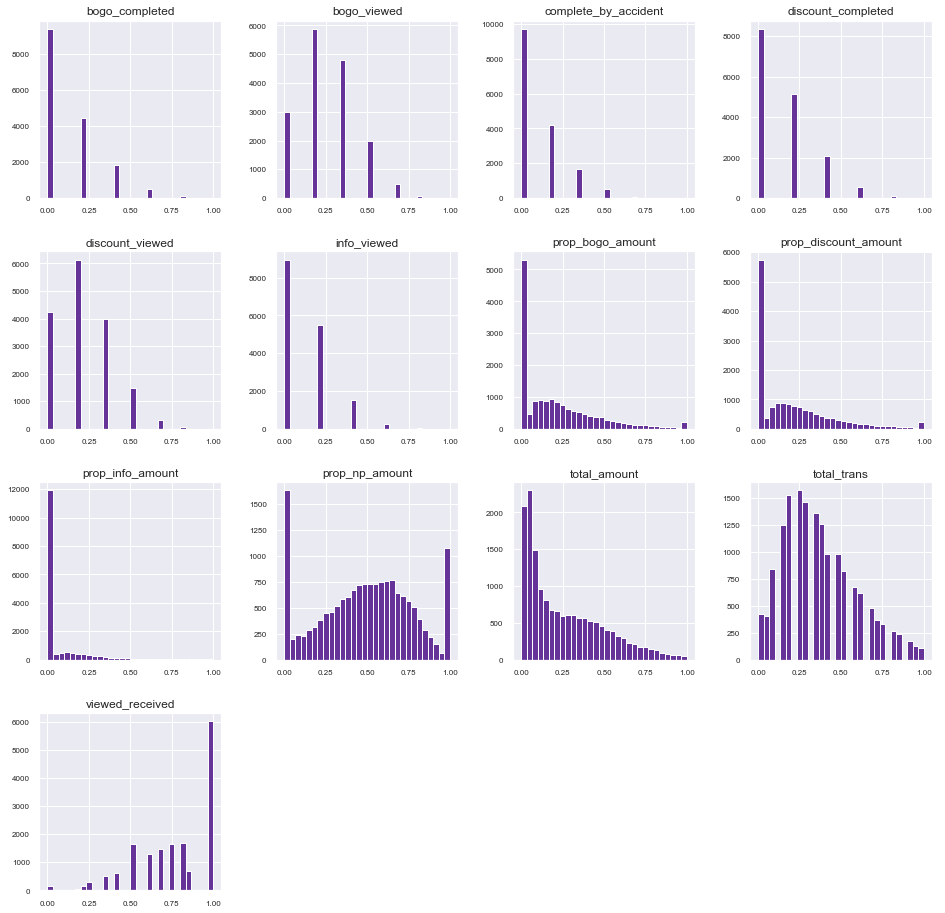

In [11]:
# apply function for natural logarithm transformation on certain columns
minmax_profile = minmax_scale(minmax_profile)
minmax_profile = pd.DataFrame(minmax_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(minmax_profile, figsize=(16, 16), bins=30)

In [12]:
"""MaxAbs-Scaling, outliers removed (not for prop_info_amount!)"""

# clean outliers for total transactions, total amount
maxabs_profile = profile.copy()
cleaning.remove_outliers_IQR_method(maxabs_profile, outlier_cols=['total_amount', 'total_trans'])
len(maxabs_profile)

total_amount
Rows removed: 521

total_trans
Rows removed: 265


Rows removed in total: 786



16214

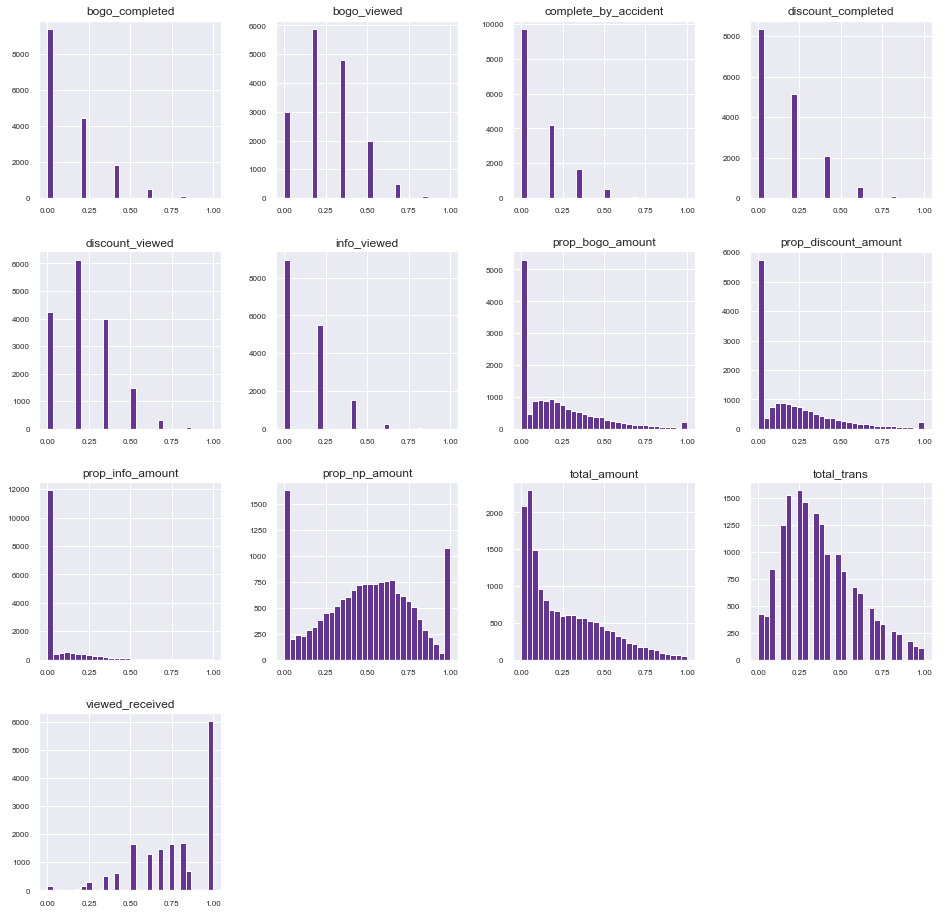

In [13]:
# apply function for natural logarithm transformation on certain columns
maxabs_profile = maxabs_scale(maxabs_profile)
maxabs_profile = pd.DataFrame(maxabs_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(maxabs_profile, figsize=(16, 16), bins=30)

**Observation:** with no negative values, the result is exactly the same as with min max scaling ...

## Create Test-Sets 2: Normalized

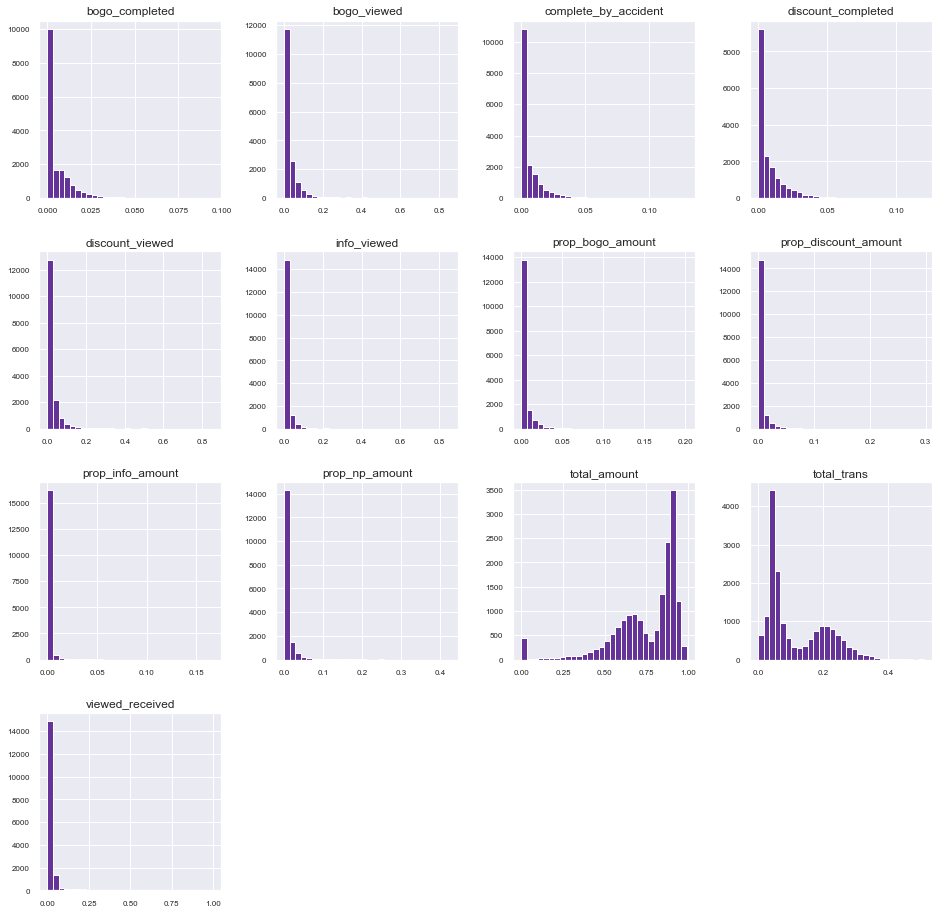

In [14]:
"""normalizing to l2 norm"""

normal_profile = normalize(profile, norm='l1')
normal_profile = pd.DataFrame(normal_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(normal_profile, figsize=(16, 16), bins=30)

### Create Test-Set 3: Log-Transformed

In [15]:
"""define log-transformation function"""

def apply_log(df, cols_to_transform=None, treat_NaN=False, rename=False):
    """Transform values of selected columns to Log10. NaN are not 
    affected by default, parameter can be changed. Returns transformed 
    DataFrame, column names have "_log" appended if parameter is set.

    ARGUMENTS:
        df: DataFrame
        cols_to_transform: list of columns that will have log-transformation 
            applied. Default is all numerical columns.
        treat_NaN: bool, set NaN to small negative value (default=False)
        rename: bool, rename column with appendix (default=False)

    RETURNS:
        df: log-transformed dataframe
    """

    cols_to_transform = cols_to_transform if cols_to_transform is not None else \
        list(df.select_dtypes(include = ['float64', 'int64']).columns)

    for col in df[cols_to_transform]:
        if col in df:
            df[col] = df[col].apply(lambda x: np.log(max(x,0.01)))
            if treat_NaN:
                df[col].replace(np.nan, -1, inplace=True)
        else:
            display(col + " not found")

        #rename transformed columns
        if rename:
            df.rename(columns={col: col+'_log'}, inplace=True)

    return df

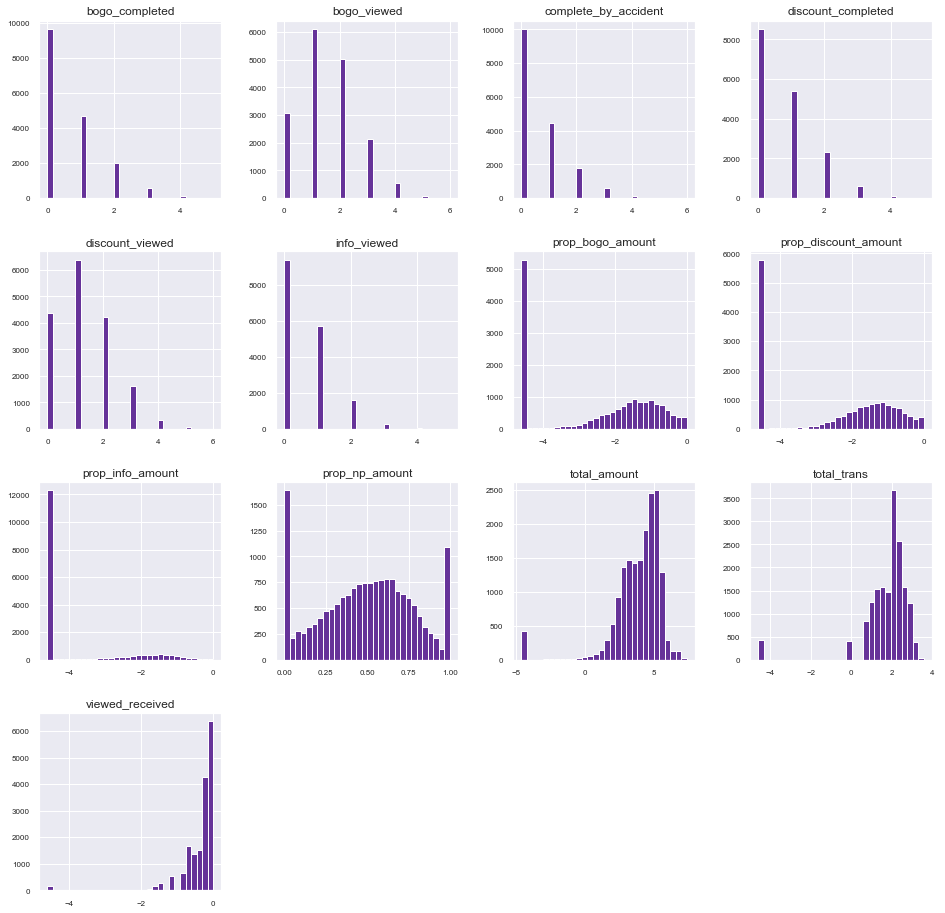

In [16]:
# apply function for transformation on certain columns
log_profile = apply_log(profile.copy(), cols_to_transform=['prop_bogo_amount', 'prop_discount_amount', 'prop_info_amount', 
                                                     'total_amount', 'total_trans', 'viewed_received'])

# check results
EDA.plot_num_hist(log_profile, figsize=(16, 16), bins=30)

In [17]:
"""remove oultiers"""

# count outliers (<> IQR=1.5)
cleaning.count_outliers_IQR_method(log_profile)

viewed_received
Identified outliers: 654
Percentage of outliers: 3.8%

total_trans
Identified outliers: 422
Percentage of outliers: 2.5%

total_amount
Identified outliers: 513
Percentage of outliers: 3.0%

prop_np_amount
Identified outliers: 0
Percentage of outliers: 0.0%

bogo_completed
Identified outliers: 667
Percentage of outliers: 3.9%

bogo_viewed
Identified outliers: 632
Percentage of outliers: 3.7%

prop_bogo_amount
Identified outliers: 0
Percentage of outliers: 0.0%

discount_completed
Identified outliers: 743
Percentage of outliers: 4.4%

discount_viewed
Identified outliers: 2
Percentage of outliers: 0.0%

prop_discount_amount
Identified outliers: 0
Percentage of outliers: 0.0%

info_viewed
Identified outliers: 286
Percentage of outliers: 1.7%

prop_info_amount
Identified outliers: 122
Percentage of outliers: 0.7%

complete_by_accident
Identified outliers: 711
Percentage of outliers: 4.2%



In [18]:
# clean outliers for total transactions, total amount, prop_info_amount
cleaning.remove_outliers_IQR_method(log_profile, outlier_cols=['total_amount', 'total_trans', 'prop_info_amount'])
len(log_profile)

total_amount
Rows removed: 513

total_trans
Rows removed: 338

prop_info_amount
Rows removed: 0


Rows removed in total: 851



16149

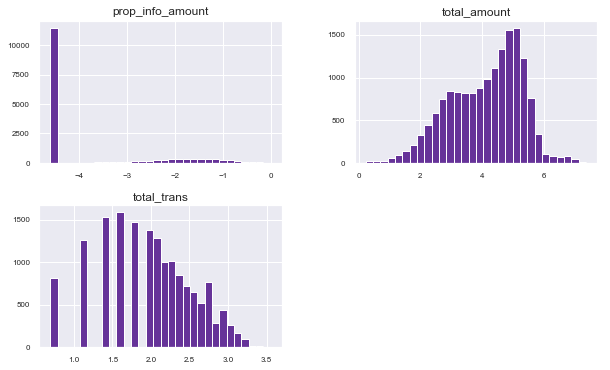

In [19]:
# check results
EDA.plot_num_hist(log_profile[['total_amount', 'total_trans', 'prop_info_amount']], figsize=(10, 6), bins=30)

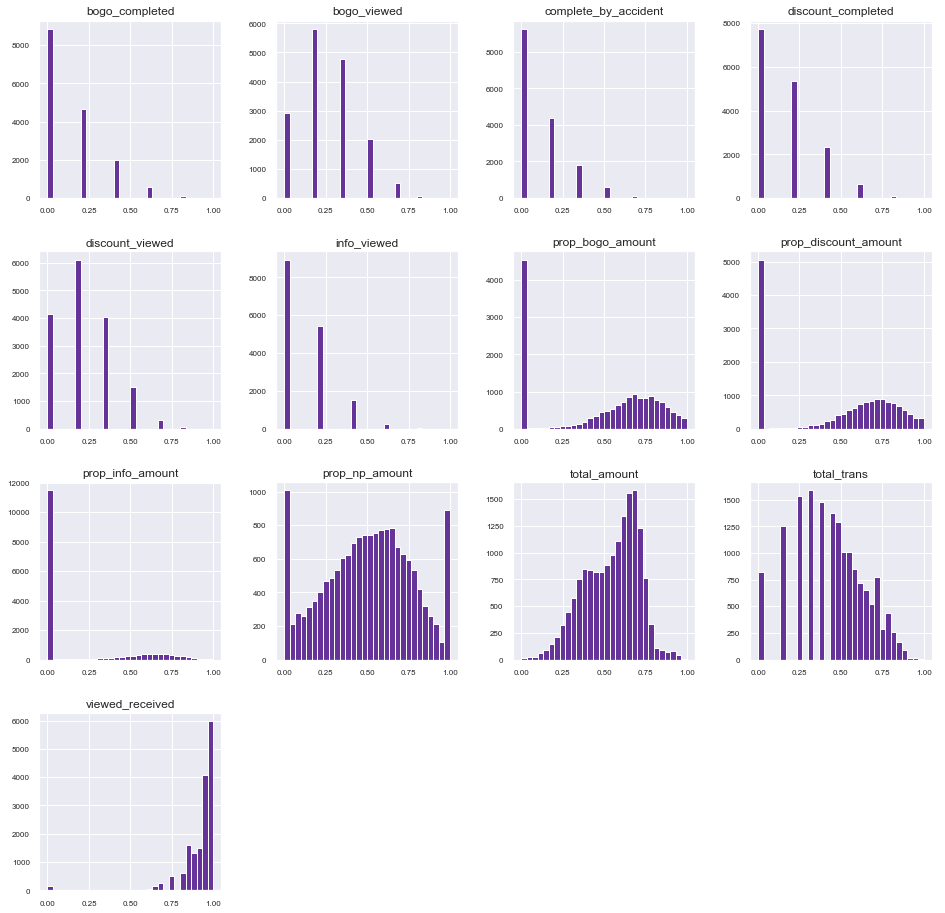

In [188]:
"""scale data to range (0,1)"""

log_scaled_profile = minmax_scale(log_profile)
log_scaled_profile = pd.DataFrame(log_scaled_profile, columns=profile.columns, index=log_profile.index)

# check results
EDA.plot_num_hist(log_scaled_profile, figsize=(16, 16), bins=30)

### Create Test-Set 3: Box-Cox-Transformed

In [21]:
"""define box-cox-transformation function"""

def apply_box_cox(df, cols_to_transform=None, treat_NaN=False, rename=False):
    """Transform values of selected columns with box-cox Returns transformed 
    DataFrame, column names have "_bc" appended if parameter is set.
    # NaN are not affected by default, parameter can be changed. HAVE TO CHECK THIS!

    ARGUMENTS:
        df: DataFrame
        cols_to_transform: list of columns that will have bc-transformation 
            applied. Default is all numerical columns.
        treat_NaN: bool, set NaN to small negative value (default=False)
        rename: bool, rename column with appendix (default=False)

    RETURNS:
        df: box-cox-transformed dataframe
    """

    cols_to_transfrom = cols_to_transform if cols_to_transform is not None else \
        list(df.select_dtypes(include = ['float64', 'int64']).columns)

    for col in df[cols_to_transform]:
        if col in df:
            df[col] = df[col].apply(lambda x : x + 0.01 if x == 0 else x)
            df[col] = stats.boxcox(df[col])[0]
        else:
            display(col + " not found")

        #rename transformed columns
        if rename:
            df.rename(columns={col: col+'_bc'}, inplace=True)

    return df

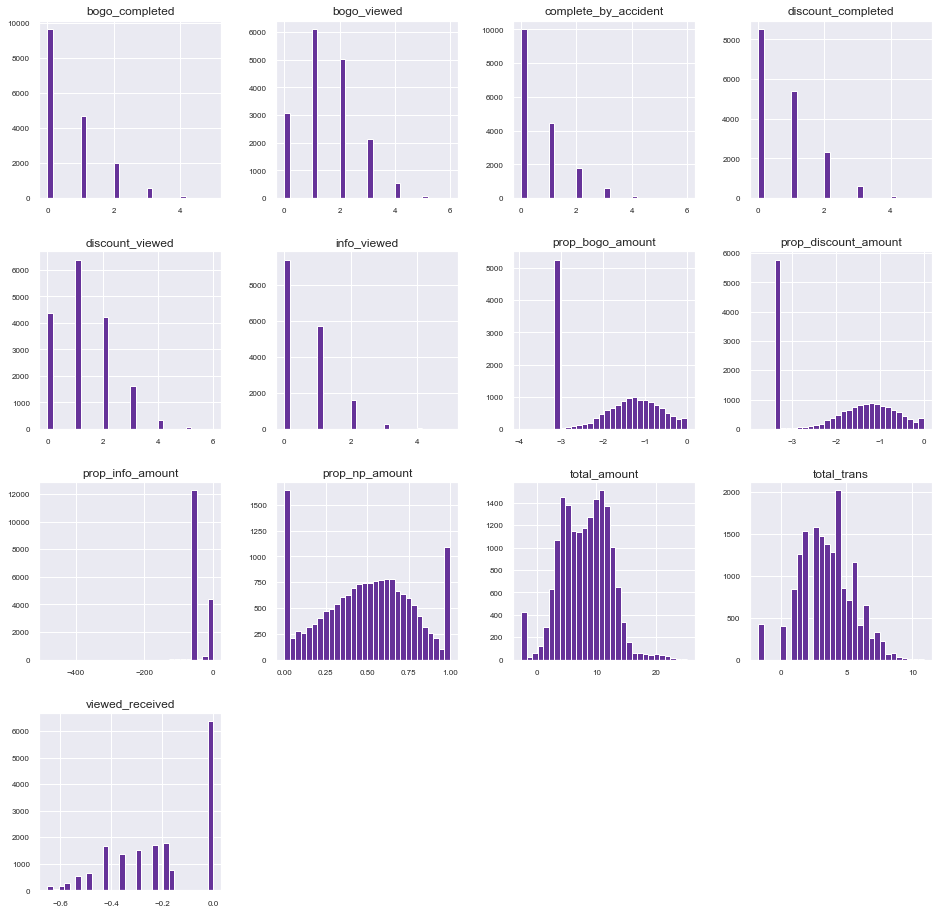

In [22]:
# apply function for transformation on certain columns
bc_profile = apply_box_cox(profile.copy(), cols_to_transform=['prop_bogo_amount', 'prop_discount_amount', 'prop_info_amount', 
                                                     'total_amount', 'total_trans', 'viewed_received'])

# check results
EDA.plot_num_hist(bc_profile, figsize=(16, 16), bins=30)

In [23]:
"""remove oultiers"""

# count outliers (<> IQR=1.5)
cleaning.count_outliers_IQR_method(bc_profile)

viewed_received
Identified outliers: 0
Percentage of outliers: 0.0%

total_trans
Identified outliers: 25
Percentage of outliers: 0.1%

total_amount
Identified outliers: 106
Percentage of outliers: 0.6%

prop_np_amount
Identified outliers: 0
Percentage of outliers: 0.0%

bogo_completed
Identified outliers: 667
Percentage of outliers: 3.9%

bogo_viewed
Identified outliers: 632
Percentage of outliers: 3.7%

prop_bogo_amount
Identified outliers: 0
Percentage of outliers: 0.0%

discount_completed
Identified outliers: 743
Percentage of outliers: 4.4%

discount_viewed
Identified outliers: 2
Percentage of outliers: 0.0%

prop_discount_amount
Identified outliers: 0
Percentage of outliers: 0.0%

info_viewed
Identified outliers: 286
Percentage of outliers: 1.7%

prop_info_amount
Identified outliers: 14
Percentage of outliers: 0.1%

complete_by_accident
Identified outliers: 711
Percentage of outliers: 4.2%



In [24]:
# clean outliers for total transactions and total amount
cleaning.remove_outliers_IQR_method(bc_profile, outlier_cols=['total_amount', 'total_trans', 'prop_info_amount'])
len(bc_profile)

total_amount
Rows removed: 106

total_trans
Rows removed: 25

prop_info_amount
Rows removed: 14


Rows removed in total: 145



16855

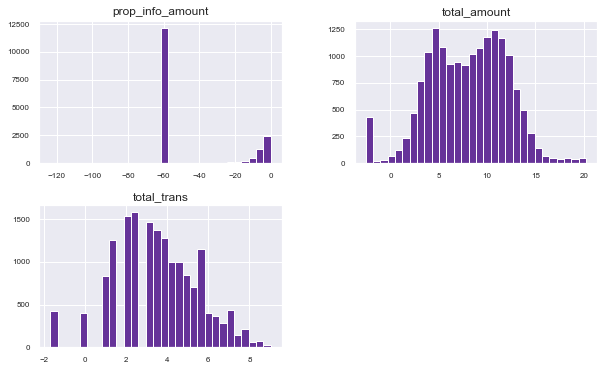

In [25]:
# check results
EDA.plot_num_hist(bc_profile[['total_amount', 'total_trans', 'prop_info_amount']], figsize=(10, 6), bins=30)

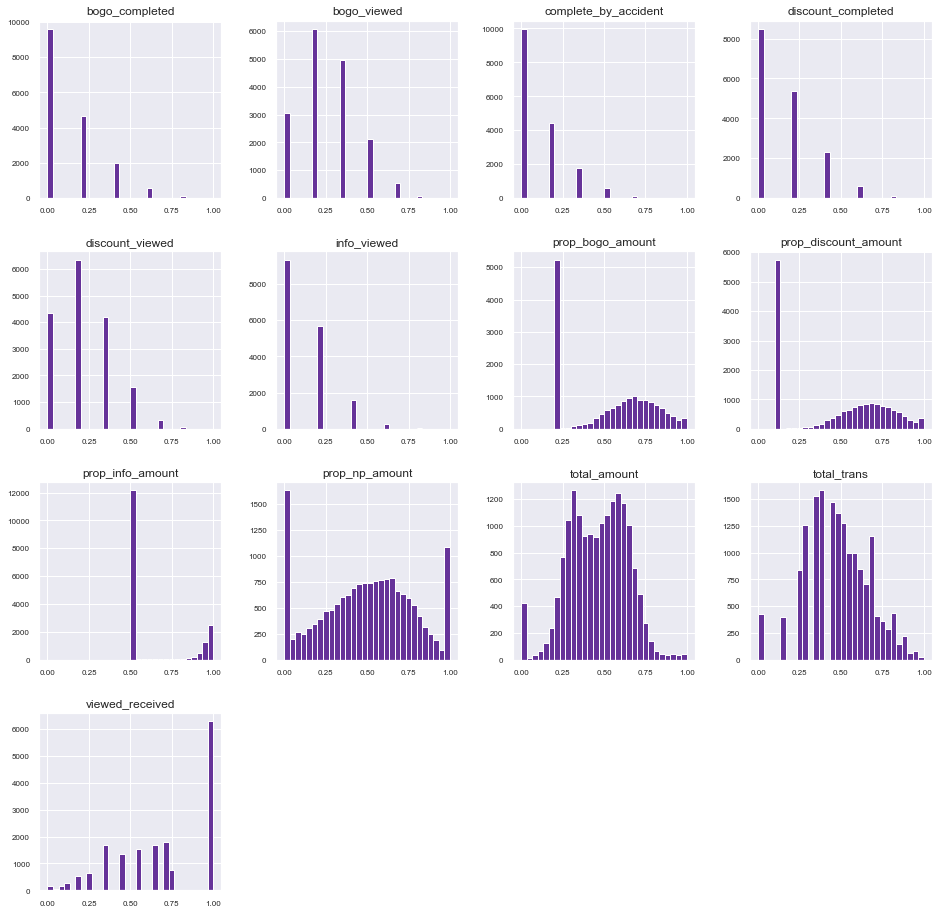

In [26]:
"""scale data to range (0,1)"""

bc_scaled_profile = minmax_scale(bc_profile)
bc_scaled_profile = pd.DataFrame(bc_scaled_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(bc_scaled_profile, figsize=(16, 16), bins=30)

### Create Test-Set 4: Yeo-Johnson-transformed

In [27]:
"""define yeo-johnson-transformation function"""

def apply_yeo_j(df, cols_to_transform=None, treat_NaN=False, rename=False):
    """Transform values of selected columns with box-cox Returns transformed 
    DataFrame, column names have "_yj" appended if parameter is set.
    # NaN are not affected by default, parameter can be changed. HAVE TO CHECK THIS!

    ARGUMENTS:
        df: DataFrame
        cols_to_transform: list of columns that will have bc-transformation 
            applied. Default is all numerical columns.
        treat_NaN: bool, set NaN to small negative value (default=False)
        rename: bool, rename column with appendix (default=False)

    RETURNS:
        df: box-cox-transformed dataframe
    """

    cols_to_transfrom = cols_to_transform if cols_to_transform is not None else \
        list(df.select_dtypes(include = ['float64', 'int64']).columns)

    for col in df[cols_to_transform]:
        if col in df:
            df[col] = stats.yeojohnson(df[col])[0]
        else:
            display(col + " not found")

        #rename transformed columns
        if rename:
            df.rename(columns={col: col+'_yj'}, inplace=True)

    return df

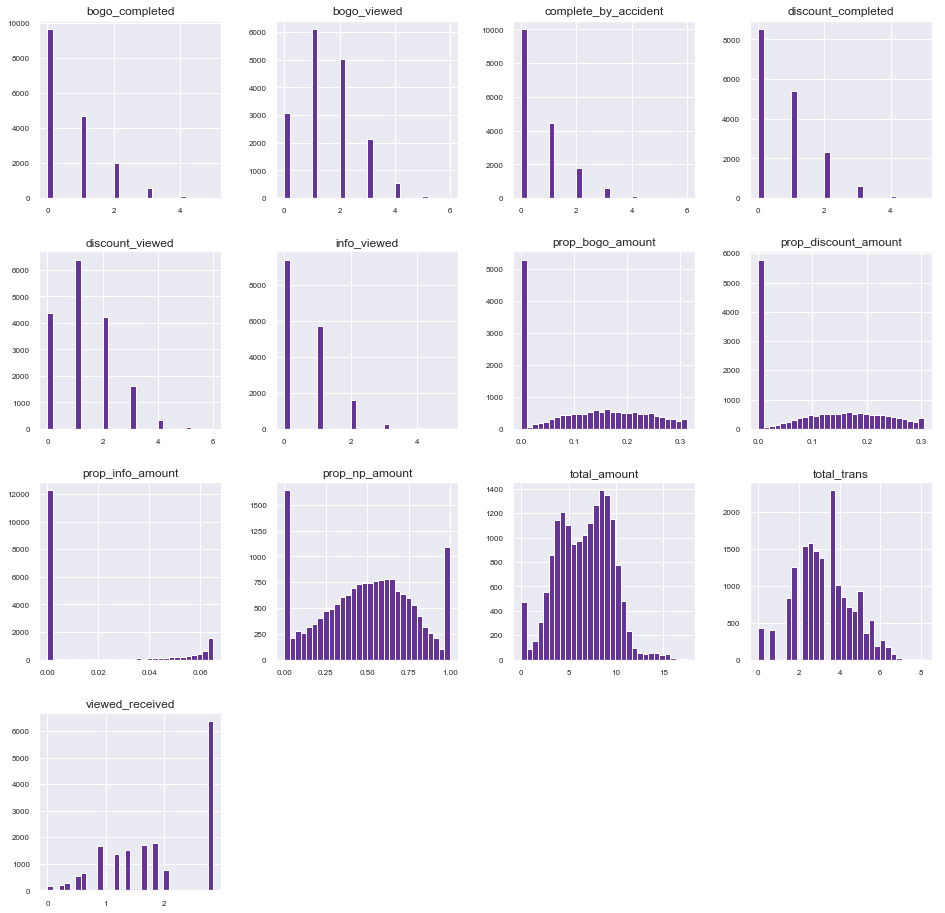

In [28]:
# apply function for transformation on certain columns
yj_profile = apply_yeo_j(profile.copy(), cols_to_transform=['prop_bogo_amount', 'prop_discount_amount', 'prop_info_amount', 
                                                     'total_amount', 'total_trans', 'viewed_received'])

# check results
EDA.plot_num_hist(yj_profile, figsize=(16, 16), bins=30)

In [29]:
"""remove oultiers"""

# count outliers (<> IQR=1.5)
cleaning.count_outliers_IQR_method(yj_profile)

viewed_received
Identified outliers: 0
Percentage of outliers: 0.0%

total_trans
Identified outliers: 18
Percentage of outliers: 0.1%

total_amount
Identified outliers: 46
Percentage of outliers: 0.3%

prop_np_amount
Identified outliers: 0
Percentage of outliers: 0.0%

bogo_completed
Identified outliers: 667
Percentage of outliers: 3.9%

bogo_viewed
Identified outliers: 632
Percentage of outliers: 3.7%

prop_bogo_amount
Identified outliers: 0
Percentage of outliers: 0.0%

discount_completed
Identified outliers: 743
Percentage of outliers: 4.4%

discount_viewed
Identified outliers: 2
Percentage of outliers: 0.0%

prop_discount_amount
Identified outliers: 0
Percentage of outliers: 0.0%

info_viewed
Identified outliers: 286
Percentage of outliers: 1.7%

prop_info_amount
Identified outliers: 0
Percentage of outliers: 0.0%

complete_by_accident
Identified outliers: 711
Percentage of outliers: 4.2%



In [30]:
# clean outliers for total transactions and total amount
cleaning.remove_outliers_IQR_method(yj_profile, outlier_cols=['total_amount', 'total_trans', 'prop_info_amount'])
len(yj_profile)

total_amount
Rows removed: 46

total_trans
Rows removed: 18

prop_info_amount
Rows removed: 0


Rows removed in total: 64



16936

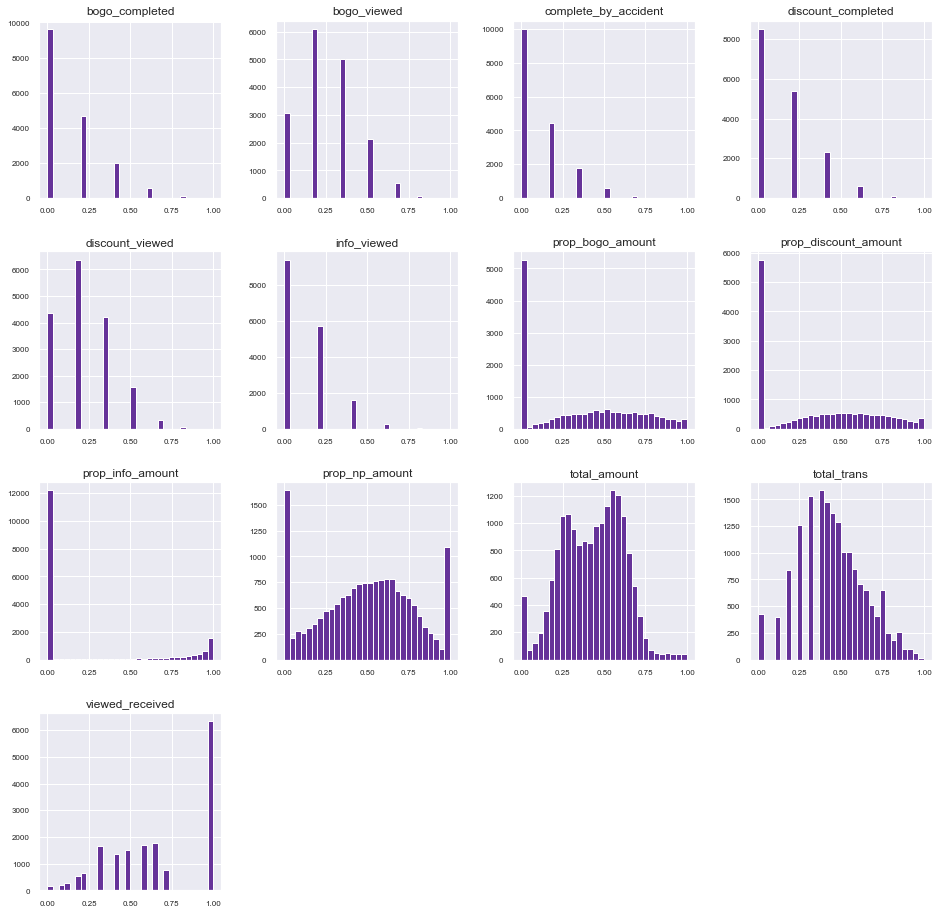

In [31]:
"""scale data to range (0,1)"""

yj_scaled_profile = minmax_scale(yj_profile)
yj_scaled_profile = pd.DataFrame(yj_scaled_profile, columns=profile.columns)

# check results
EDA.plot_num_hist(yj_scaled_profile, figsize=(16, 16), bins=30)

## Apply PCA

In [32]:
""" apply PCA with the goal to retain 95% of the variance"""

# initialize pca class object
pca = PCA(n_components=0.95) # PCA(n_components=bc_profile.shape[1])

# define function to apply pca and visualize the results
def pca_results(df, pca):
    ''' Create a DataFrame of the PCA results that includes dimension feature 
    weights and explained variance and visusalize the results with a bar chart.

    ARGUMENTS:
        - df: dataframe
        - pca: fitted sklearn PCA class object
        
    RETURNS:
        - pca_results: dataframe with pca results
        - Plot of PCA results (bar chart)
    '''
    
    pca.fit(df)

    # index dimensions, pca components, explained variance
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(df.keys()))
    components.index = dimensions
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # create a bar plot visualization: plot feature weights as function of components
    fig, ax = plt.subplots(figsize = (18,12))

    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    plt.legend(loc='lower right')

    # display explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n%.4f"%(ev))

    # return concatenated DataFrame
    pca_results = pd.concat([variance_ratios, components], axis = 1)
    pca_results

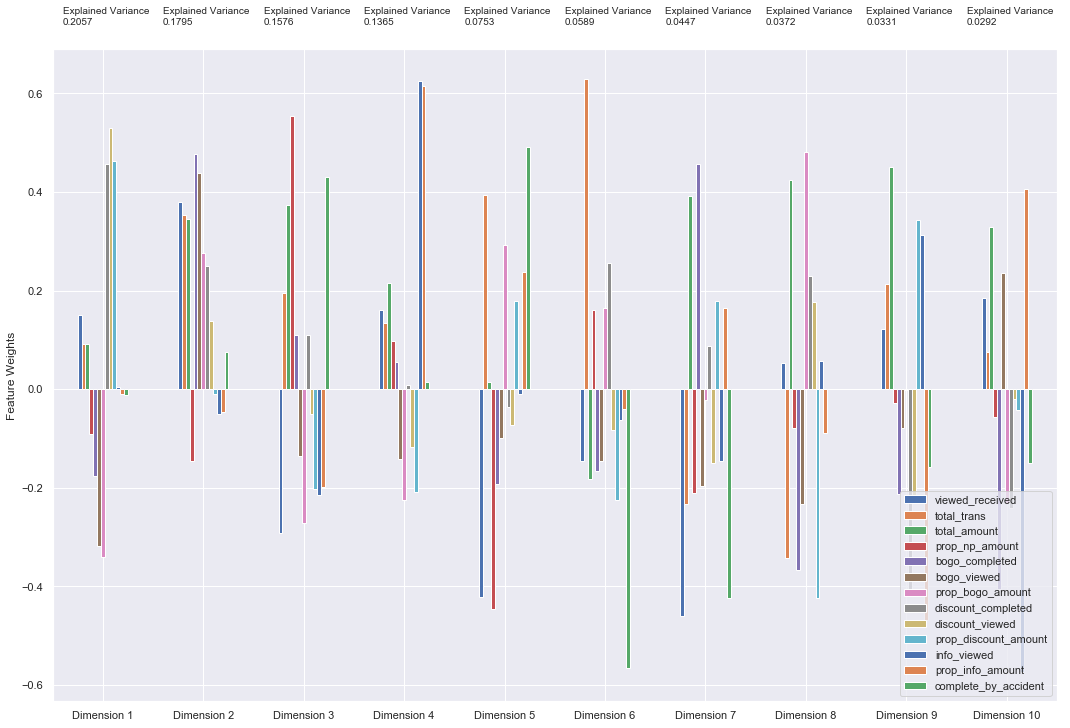

In [33]:
# call function
pca_results(standard_profile, pca)

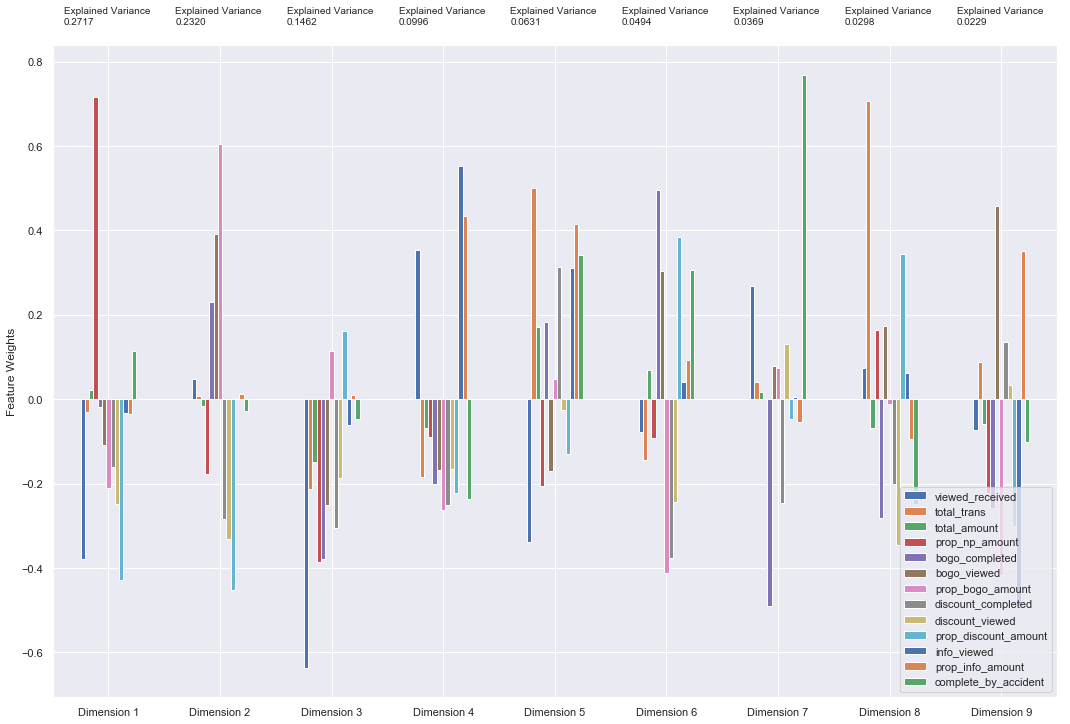

In [34]:
# call function
pca_results(robust_profile, pca)

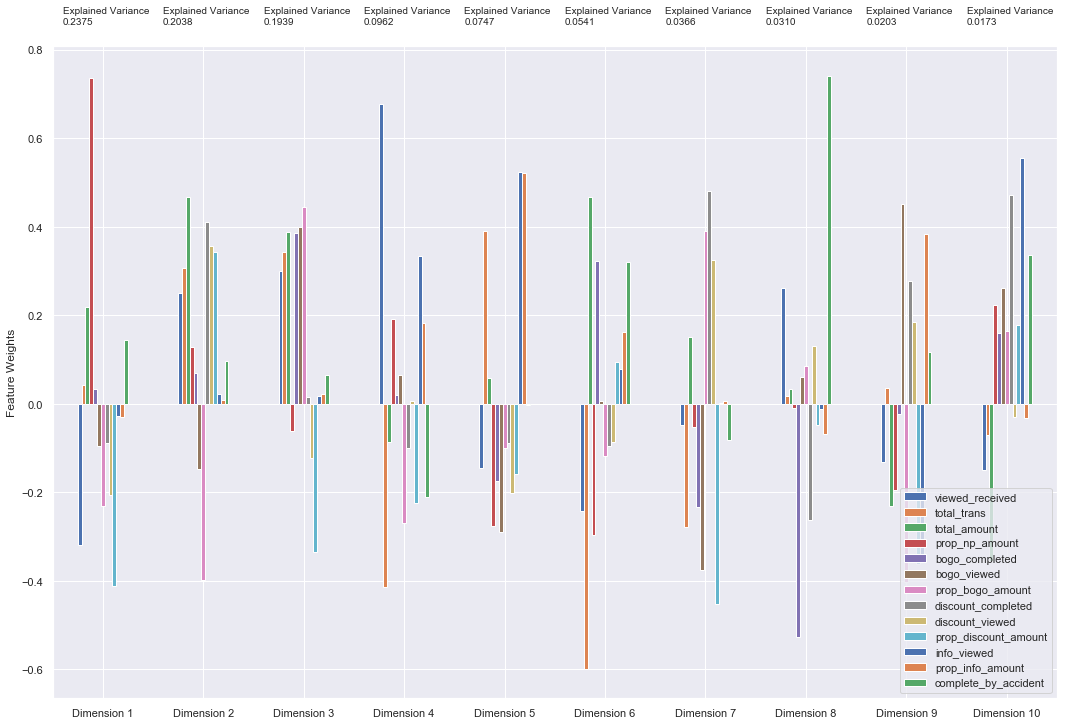

In [35]:
# call function
pca_results(minmax_profile, pca)

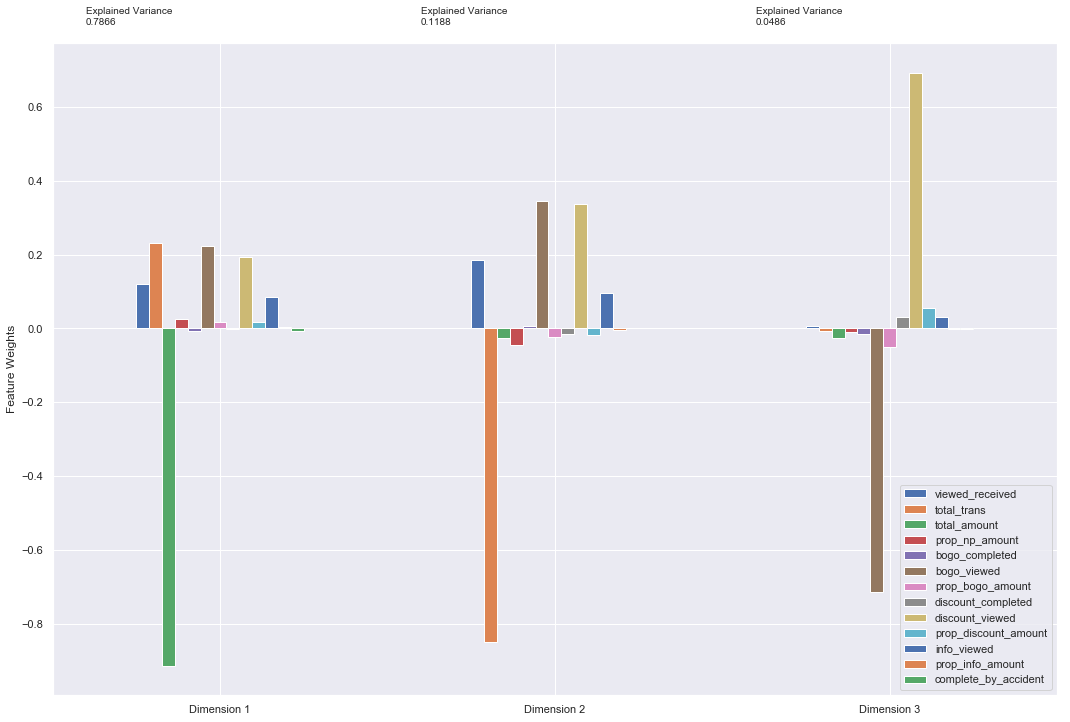

In [36]:
# call function
pca_results(normal_profile, pca)

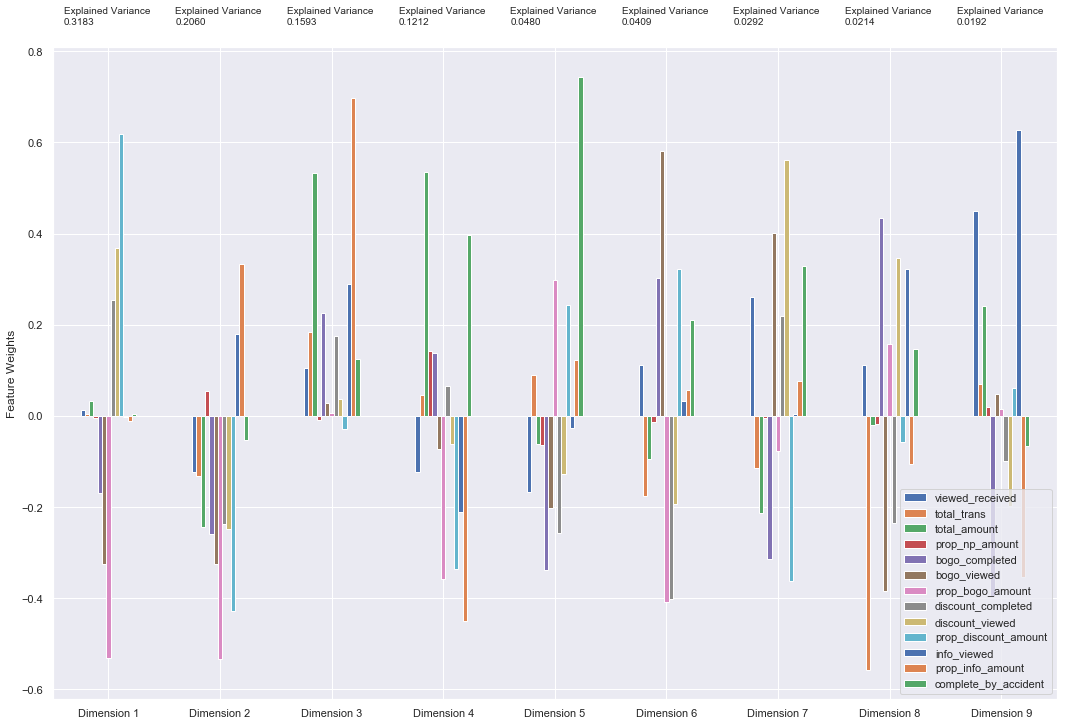

In [37]:
# call function
pca_results(log_profile, pca)

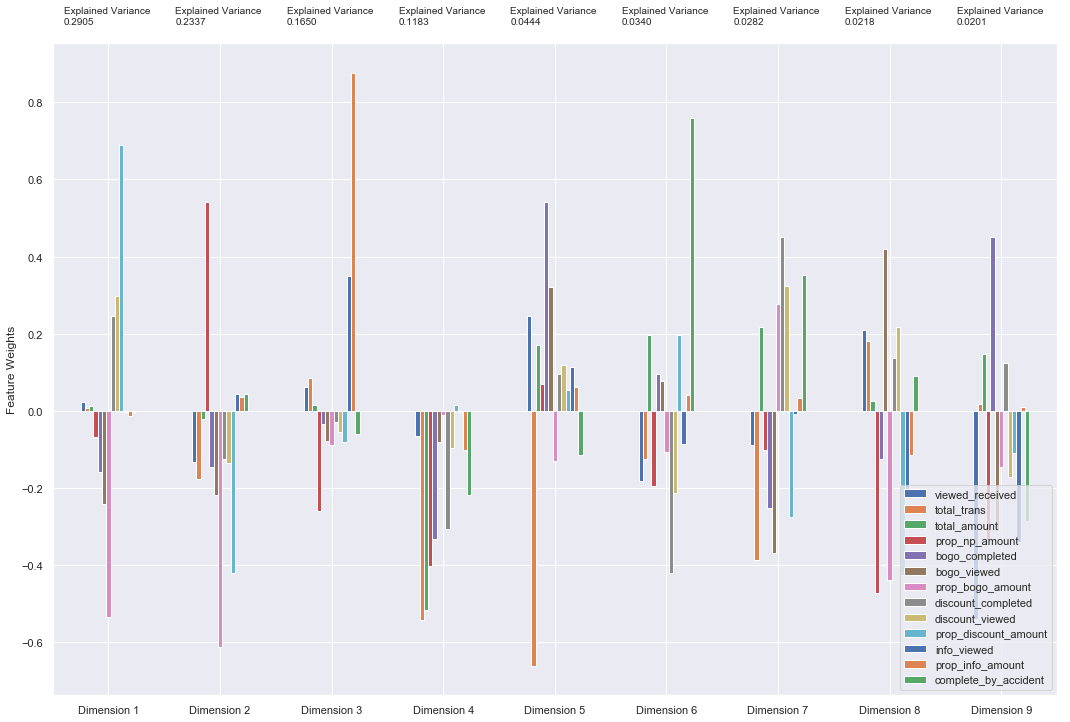

In [38]:
# call function
pca_results(log_scaled_profile, pca)

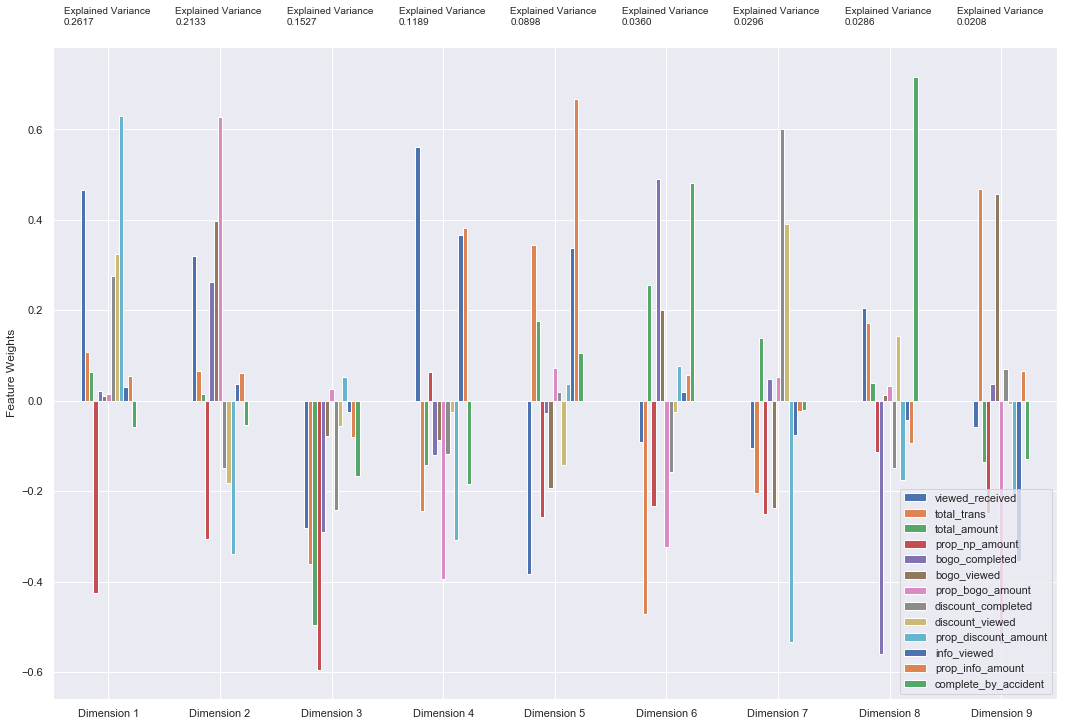

In [39]:
# call function
pca_results(bc_scaled_profile, pca)

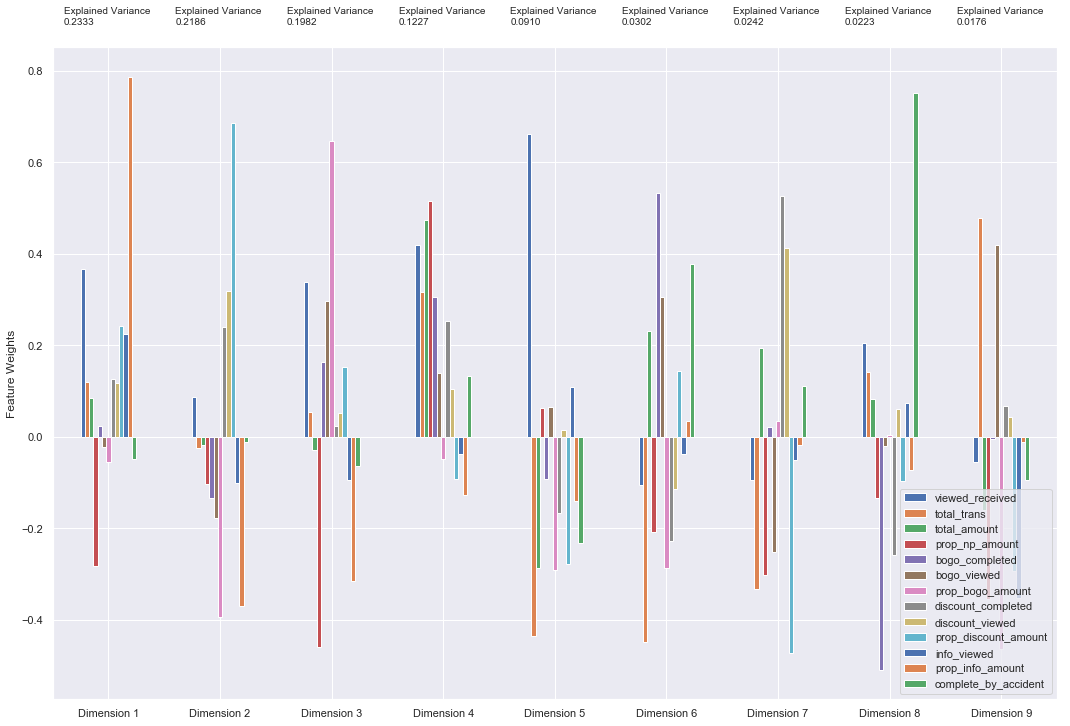

In [40]:
# call function
pca_results(yj_scaled_profile, pca)

### Apply PCA

**Note:** The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

In [128]:
pca2 = PCA(n_components=2)

# transform the good data using the PCA fit above
reduced_profile = pca2.fit_transform(log_scaled_profile)
reduced_profile = pd.DataFrame(reduced_profile, columns=['Dimension 1', 'Dimension 2'])

In [155]:
def create_biplot(orig_df, reduced_df, pca):
    '''Create a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.

    

    orig_df: original data, before transformation.

               Needs to be a pandas dataframe with valid column names

    reduced_df: the reduced data (the first two dimensions are plotted)

    pca: pca object that contains the components_ attribute



    return: a matplotlib AxesSubplot object (for any additional customization)

    

    This procedure is inspired by the script:

    https://github.com/teddyroland/python-biplot

    '''



    fig, ax = plt.subplots(figsize = (18,12))

    # scatterplot of the reduced data    

    ax.scatter(x=reduced_df.loc[:, 'Dimension 1'], y=reduced_df.loc[:, 'Dimension 2'], 

        facecolors='b', edgecolors='b', s=70, alpha=0.5)

    

    feature_vectors = pca.components_.T



    # we use scaling factors to make the arrows easier to see

    arrow_size, text_pos = 1.5, 2



    # projections of the original features

    for i, v in enumerate(feature_vectors):

        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 

                  head_width=0.1, head_length=0.1, linewidth=2, color='red')

        ax.text(v[0]*text_pos, v[1]*text_pos, orig_df.columns[i], color='black', 

                 ha='center', va='center', fontsize=18)



    ax.set_xlabel("Dimension 1", fontsize=14)

    ax.set_ylabel("Dimension 2", fontsize=14)

    ax.set_title("PC plane with original feature projections.", fontsize=16);

    return ax

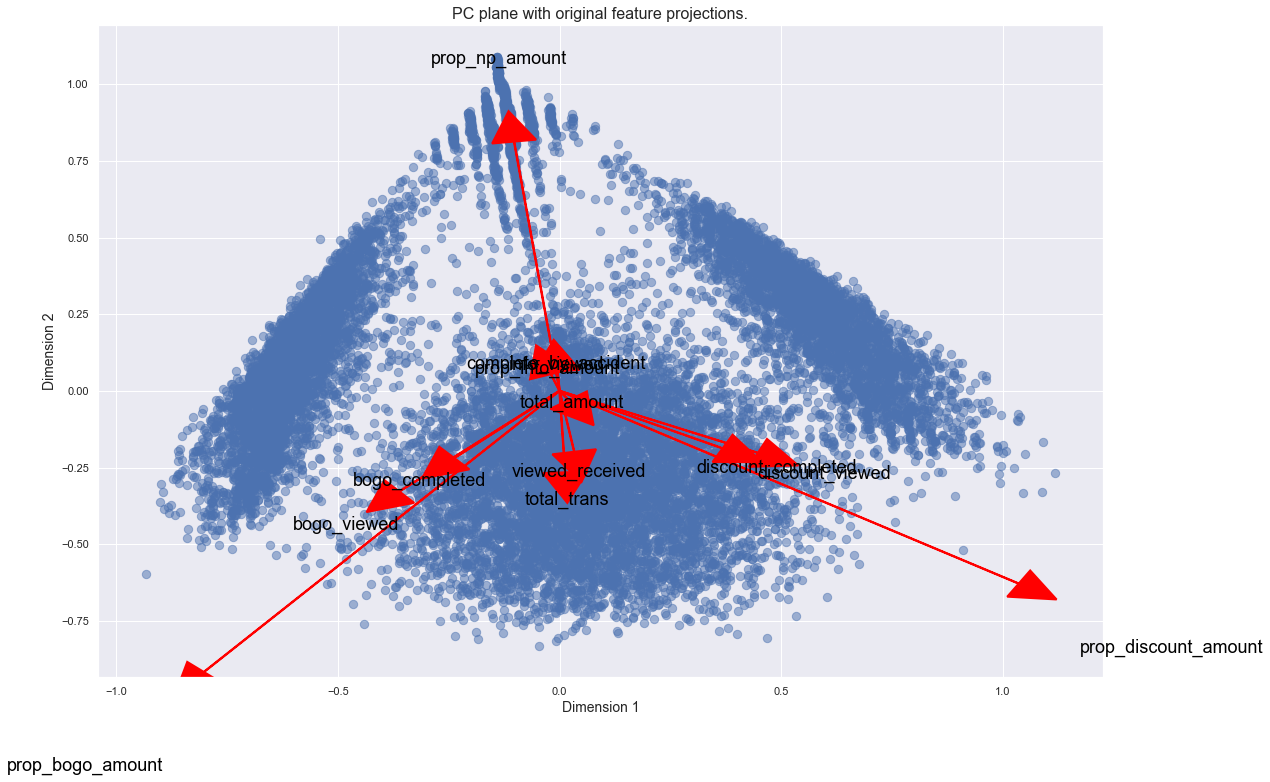

In [156]:
# call function
create_biplot(profile, reduced_profile, pca2);

## Apply k-means Clustering

In [102]:
pca3 = PCA(n_components=4)

# transform the good data using the PCA fit above
reduced_3_profile = pca3.fit_transform(yj_scaled_profile)

In [103]:
# apply k-means to the reduced data, output silhouette score for different cluster numbers


range_n_clusters = [2, 4, 6, 8]

for nc in range_n_clusters:
    kmeans = KMeans(n_clusters=nc)   
    kmeans.fit(reduced_3_profile)

    # predict the cluster for each data point
    preds = kmeans.predict(reduced_3_profile)
    # find the cluster centers
    centers = kmeans.cluster_centers_ 
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_3_profile, preds)

    print(nc, score)

2 0.3160870720123001
4 0.28125512836480804
6 0.26860009812547153
8 0.277490622589126


In [74]:
# apply k-means to the un-reduced data, output silhouette score for different cluster numbers


range_n_clusters = [2, 4, 6, 8]

for nc in range_n_clusters:
    kmeans = KMeans(n_clusters=nc)   
    kmeans.fit(yj_scaled_profile)

    # predict the cluster for each data point
    preds = kmeans.predict(yj_scaled_profile)
    # find the cluster centers
    centers = kmeans.cluster_centers_ 
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(yj_scaled_profile, preds)

    print(nc, score)

2 0.24166181309370233
4 0.20211453249511607
6 0.1819340543184419
8 0.1956108993348677


In [143]:
pca5 = PCA(n_components=2)

# transform the good data using the PCA fit above
reduced_5_profile = pca5.fit_transform(log_scaled_profile)

In [145]:
# apply k-means to the reduced data, output silhouette score for different cluster numbers


range_n_clusters = [3, 4, 5]

for nc in range_n_clusters:
    kmeans = KMeans(n_clusters=nc)   
    kmeans.fit(reduced_5_profile)

    # predict the cluster for each data point
    preds = kmeans.predict(reduced_5_profile)
    # find the cluster centers
    centers = kmeans.cluster_centers_ 
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_5_profile, preds)

    print(nc, score)

3 0.46078164242315023
4 0.5169174747482461
5 0.4636177926388662


In [140]:
pca3 = PCA(n_components=4)

# transform the good data using the PCA fit above
reduced_3_profile = pca3.fit_transform(yj_scaled_profile)

In [79]:
unique, counts = np.unique(preds, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 1034]
 [   1 2360]
 [   2 3248]
 [   3 1208]
 [   4 1378]
 [   5 2435]
 [   6 2699]
 [   7 1787]]


### Apply hierarchical clustering

Note: `complete` linkage was tried, did not perform at all

In [104]:
pca4 = PCA(n_components=4)

# transform the good data using the PCA fit above
reduced_4_profile = pca4.fit_transform(yj_scaled_profile)

In [112]:
from sklearn.cluster import AgglomerativeClustering

# Ward is the default linkage algorithm, so we'll start with that
ward = AgglomerativeClustering(n_clusters=8)
ward_profile = ward.fit_predict(yj_scaled_profile)
ward_reduced_4 = ward.fit_predict(reduced_4_profile)

# average linkage
avg = AgglomerativeClustering(n_clusters=8, linkage='average')
avg_profile = avg.fit_predict(yj_scaled_profile)
avg_reduced_4 = avg.fit_predict(reduced_4_profile)

In [113]:
# calculate the mean silhouette coefficient for the number of clusters chosen
print(silhouette_score(reduced_4_profile, ward_reduced_4))

0.20405946475194817


In [114]:
# calculate the mean silhouette coefficient for the number of clusters chosen
print(silhouette_score(reduced_4_profile,avg_reduced_4))

0.20700231969879893


In [115]:
# calculate the mean silhouette coefficient for the number of clusters chosen
print(silhouette_score(yj_scaled_profile, ward_profile))

0.14495565697330492


In [116]:
# calculate the mean silhouette coefficient for the number of clusters chosen
print(silhouette_score(yj_scaled_profile, avg_profile))

0.12734610518126321


### Append best clusters to profile

k-means with 4 clusters on log_scaled_profile, reduced to two pc-dimensions

In [190]:
# transform using PCA
pca5 = PCA(n_components=2)
reduced_5_profile = pca5.fit_transform(log_scaled_profile)

# cluster with k-means
kmeans = KMeans(n_clusters=4)   
kmeans.fit(reduced_5_profile)

# predict the cluster for each data point
preds5 = kmeans.predict(reduced_5_profile)
# find the cluster centers
centers5 = kmeans.cluster_centers_ 
# calculate the mean silhouette coefficient for the number of clusters chosen
score5 = silhouette_score(reduced_5_profile, preds)

In [191]:
unique, counts = np.unique(preds5, return_counts=True)
display(np.asarray((unique, counts)).T)

array([[   0, 3929],
       [   1, 1583],
       [   2, 6953],
       [   3, 3684]], dtype=int64)

In [196]:
assert len(preds5) == log_scaled_profile.shape[0]

log_scaled_profile['cluster'] = preds5

In [198]:
log_scaled_profile.head()

,viewed_received,total_trans,total_amount,prop_np_amount,bogo_completed,bogo_viewed,prop_bogo_amount,discount_completed,discount_viewed,prop_discount_amount,info_viewed,prop_info_amount,complete_by_accident,cluster
p_1,1.000000,0.525497,0.389997,0.000000,0.0,0.000000,0.000000,0.4,0.833333,1.000000,0.0,0.00000,0.000000,3
p_10,0.937531,0.383835,0.352709,0.492318,0.0,0.333333,0.852796,0.0,0.000000,0.000000,0.2,0.00000,0.166667,0
p_100,0.000000,0.000000,0.461505,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.166667,1
p_1000,1.000000,0.320135,0.385687,0.675935,0.0,0.500000,0.724229,0.0,0.000000,0.000000,0.2,0.31787,0.000000,0
p_10000,1.000000,0.383835,0.246087,0.251374,0.0,0.333333,0.866407,0.0,0.166667,0.659141,0.0,0.00000,0.000000,2


In [202]:
profile_cluster = pd.concat([profile_type, log_scaled_profile[['cluster']]], axis=1, sort=True)

In [205]:
profile_grouped = profile_cluster.groupby(['cluster'])
profile_grouped.mean()

,age,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,complete_by_accident
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,53.644521,63997.123957,-535.798422,4.368796,3.101044,1.681598,0.720548,1.068465,8.093917,99.090178,10.921609,88.168570,0.118325,12.923785,4.195215,57.458226,12.429687,0.513986,0.507715,1.023925,2.161110,3.198015,33.029424,0.044541,0.223467,0.085009,0.608241,0.623568,0.691016,7.994287,0.414299,0.003098,0.074889,0.479460,0.043523,0.613133
1.0,55.120715,65640.834575,-396.959570,3.908402,2.203411,0.819962,0.570457,0.137713,5.024637,90.264245,3.948831,86.315414,0.054025,16.908682,4.080227,80.970272,19.420743,0.847317,0.893606,0.075174,0.824384,0.236260,1.511924,0.062539,0.481364,0.150347,1.085003,0.732786,0.583070,6.697047,0.011641,0.005811,0.088942,0.063592,0.056538,0.682249
2.0,54.064616,64843.121217,-577.935136,4.759241,3.943478,2.633252,0.835613,2.001007,10.036243,120.614815,12.727456,107.887359,0.121382,13.132046,4.393355,59.037674,12.069873,0.417551,0.407083,0.917733,1.791601,2.769164,26.726370,1.083273,1.610096,2.711060,28.012660,0.492449,0.550410,6.838110,0.268861,0.274656,0.049400,0.526135,0.683362,0.632245
3.0,54.782998,66469.242658,-500.547231,4.358578,3.180782,1.938925,0.740178,1.295603,7.840934,108.294992,6.464984,101.830008,0.077053,14.264221,4.346634,64.479995,13.660491,0.522853,0.516822,0.064332,0.472584,0.150923,0.989140,1.231270,1.996471,2.853692,35.435488,0.618621,0.608578,7.390369,0.005314,0.411457,0.066406,0.061754,0.630850,0.643322
